# HW 5

First we need to get a fourth-order difference method. From the Taylor series, we have
\begin{align*}
u(x+kh) = u(x) &+ (kh)u'(x) + \frac{(kh)^2}{2}u''(x)\\ &+ \frac{(kh)^3}{3!}u^{(3)}(x) + \frac{(kh)^4}{4!}u^{(4)}(x)\\
&+ \frac{(kh)^5}{5!}u^{(5)}(x) + O(h^6)\\
&+ O(h^7).
\end{align*}

We want to find coefficients $c_i$ s.t.

$$\sum_{i=1}^{6}c_iu(x+k_ih) = h^2u''(x) + O(h^6)$$

to get a fourth-order difference approximation. This is equivalent to solving the matrix equation

$$\begin{bmatrix}
1&1&\cdots&1\\
k_1&k_2&\cdots&k_6\\
k_1^2&k_2^2&\cdots&k_6^2\\
\vdots&\vdots&\ddots&\vdots\\
k_1^5&k_2^5&\cdots&k_6^5
\end{bmatrix}\begin{bmatrix}c_1\\c_2\\c_3\\\vdots\\c_6\end{bmatrix}=\begin{bmatrix}0\\0\\2\\\vdots\\0\end{bmatrix}$$

We will use the $k$-values

$$k = \langle -2, -1, 0, 1, 2\rangle$$

everywhere except when we get close to the edges. When we are one away from the edges we use the values

\begin{align*}
k_{1^+} &= \langle -1, 0, 1, 2, 3\rangle,\\
k_{1^{-}} &= \langle -3, -2, -1, 0, 1\rangle,
\end{align*}

and right on the edge we use the values

\begin{align*}
k_{0^+}&=\langle 0, 1, 2, 3, 4, 5\rangle,\\
k_{0^{-}}&=\langle -5, -4, -3, -2, -1, 0\rangle.
\end{align*}

I've coded out a more general `get_c` function below.

In [12]:
import numpy as np
from scipy.special import factorial

def get_c(k, d=2):
    """
    k - An array with which indices to use to find the difference approximation.
    d - The order of the derivatives (i.e. 2 => u'').
    """
    n = len(k)
    M = np.zeros((n, n))
    for i in range(n):
        M[i] = np.power(k, i)
    
    D = np.zeros(n)
    D[d] = factorial(d)
    
    return np.linalg.solve(M, D)

print(get_c((-1, -0.5, 0, 0.5, 1), 2))

[ -0.33333333   5.33333333 -10.           5.33333333  -0.33333333]


And here is the code to generate the finite difference matrix and solve the ODE.

In [3]:
def get_row(i, n=None, order=2, d=2):
    """
    i - row index of the matrix
    n - 1/n = h is the space between points
    order - order of the finite difference method
    d - derivative order
    """
    
    l = d + order
    if 2*i < l - 1:
        k = range(-i, l-i)
    elif n is not None and 2*(n-i) < l-1:
        k = range(n+1-i-l, n+1-i)
    else:
        k = range(-l//2, l//2)
        
    return [i+di for di in k], get_c(k, d=d)

def difference_matrix(n, order=None, d=None):
    """
    n - 1/n = h is the space between points
    order - order of the finite difference method (per point)
    d - derivative order (per point)
    """
    if order is None:
        order = [2 for i in range(n+1)]
    if d is None:
        d = [2 for i in range(n+1)]
        
    A = np.zeros((n+1, n+1))
    for i in range(n+1):
        k, c = get_row(i, n, order=order[i], d=d[i])
        A[i, k] = c
    return A

def solve_ODE(sigma, beta, fun, N, order):
    """
    Solve the ODE
        u''(x) = fun(x),
        u'(0) = sigma,
        u(1) = beta.
    using an order `order` finite difference method on an N+1 point stencil.
    """
    h = 1 / N
    order = np.full(N+1, order)
    d = np.full(N+1, 2)
    d[0] = 1
    d[-1] = 0
    
    x = np.linspace(0, 1, N+1)    
    A = difference_matrix(N, order=order, d=d)
    F = [h**2 * fun(y) for y in x]
    F[0] = h * sigma
    F[-1] = beta
    
    return x, np.linalg.solve(A, F)

def bvp_order(sigma, beta, fun, N, order):
    return solve_ODE(sigma, beta, fun, N, order)[-1]

Here's a graph for $N=100$ and sixth-order convergence:

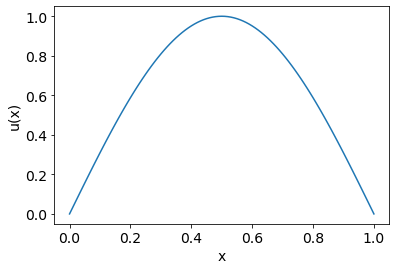

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

PI = np.pi
def fun(x):
    return -PI**2 * np.sin(PI*x)

sigma = PI
beta = 0

N = 100
order = 6

x, y = solve_ODE(sigma, beta, fun, N, order)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show();

Now we find the convergence rate. The true solution is

$$u(x) = \sin(\pi x)$$

For `order = 2` (using the infinity norm for global error):

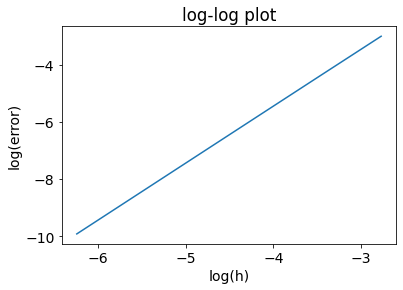

In [7]:
def u(x):
    return np.sin(PI*x)

hs = []
errors = []

for i in range(4, 10):
    N = 2**i
    x, u_approx = solve_ODE(sigma, beta, fun, N, order=2)
    
    hs.append(1 / N)
    errors.append(np.linalg.norm(u(x) - u_approx, ord=np.inf))
    
plt.plot(np.log(hs), np.log(errors))
plt.title("log-log plot")
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.show();

We calculuate the slope of the above graph pointwise to find the order of convergence. I.e. we calculate

$$\frac{\log(e_{i+1}) - \log(e_i)}{\log(h_{i+1}) - \log(h_i)}$$

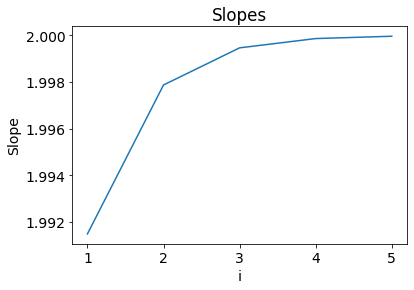

In [8]:
e = np.log(errors)
h = np.log(hs)
slopes = (e[1:] - e[:-1]) / (h[1:] - h[:-1])

plt.plot(range(1, len(e)), slopes)
plt.title("Slopes")
plt.xlabel("i")
plt.ylabel("Slope")
plt.show();

As you can see it is second order. We do the same for the fourth-order convergence test:

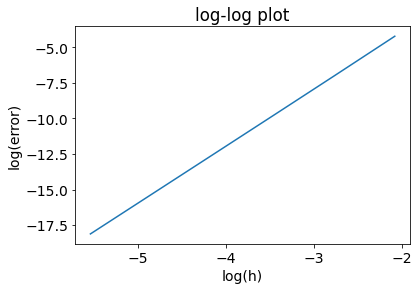

In [9]:
hs = []
errors = []

for i in range(3, 9):
    N = 2**i
    x, u_approx = solve_ODE(sigma, beta, fun, N, order=4)
    
    hs.append(1 / N)
    errors.append(np.linalg.norm(u(x) - u_approx, ord=np.inf))
    
plt.plot(np.log(hs), np.log(errors))
plt.title("log-log plot")
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.show();

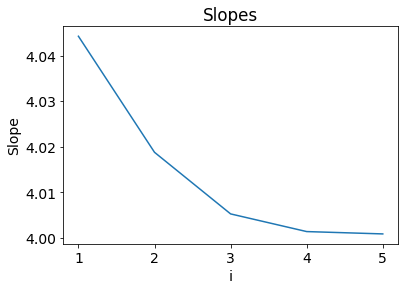

In [10]:
e = np.log(errors)
h = np.log(hs)
slopes = (e[1:] - e[:-1]) / (h[1:] - h[:-1])

plt.plot(range(1, len(e)), slopes)
plt.title("Slopes")
plt.xlabel("i")
plt.ylabel("Slope")
plt.show();

As you can see, it is fourth order. Now let's try it with sixth order:

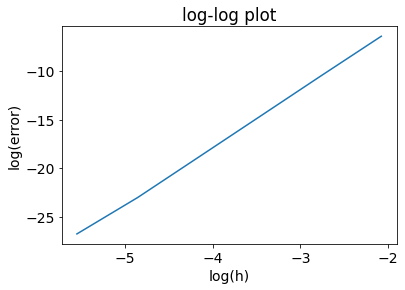

In [11]:
hs = []
errors = []

for i in range(3, 9):
    N = 2**i
    x, u_approx = solve_ODE(sigma, beta, fun, N, order=6)
    
    hs.append(1 / N)
    errors.append(np.linalg.norm(u(x) - u_approx, ord=np.inf))
    
plt.plot(np.log(hs), np.log(errors))
plt.title("log-log plot")
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.show();

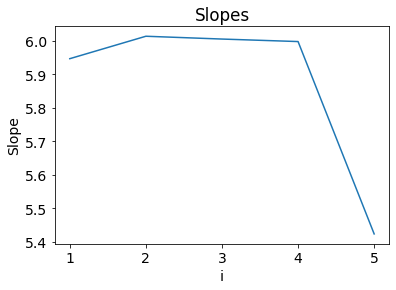

In [12]:
e = np.log(errors)
h = np.log(hs)
slopes = (e[1:] - e[:-1]) / (h[1:] - h[:-1])

plt.plot(range(1, len(e)), slopes)
plt.title("Slopes")
plt.xlabel("i")
plt.ylabel("Slope")
plt.show();

The order starts dropping off for larger values of $N$, but it is 6th order for the smaller values.